In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

[Link To Data](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

In [22]:
# load in data
df = pd.read_csv("heart_failure_data.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


# Exploratory Data Analysis (EDA)

### EDA Plan: What questions do we want to ask of the data?
1. Tabular descriptors to get a basic sense of the types of features in the dataset
2. How many positive and negative examples are there of the target variable?
3. How are continuous variables distributed (in particular, are they normally distributed)?
4. How do continuous variables change in conjunction with the target variable?
5. How many examples are there of each categorical variable?
6. How does each categorical variable change in conjunction with the target variable?

## EDA Step 1: Tabular Descriptors

In [ ]:
df.columns

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')

### Attribute information:
1. Age: age of the patient [years]
2. Sex: sex of the patient [M: Male, F: Female]
3. ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
4. RestingBP: resting blood pressure [mm Hg]
5. Cholesterol: serum cholesterol [mm/dl]
6. FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

In [ ]:
# Summary statistics for numerical features
numerical_features = df.select_dtypes(include=[np.number])
numerical_features = numerical_features.drop(["HeartDisease", "FastingBS"], axis=1)
numerical_features.describe()

In [ ]:
# Summary statistics for categorical features
categorical_features = df.select_dtypes(include=[object])
categorical_features.describe()

In [ ]:
df.info()

In [ ]:
# Check for null values in the dataset
df.isnull().sum()  # there are none, great [although later I find that cholesterol has null values set to 0]

## EDA step 2: visualizing the dataset

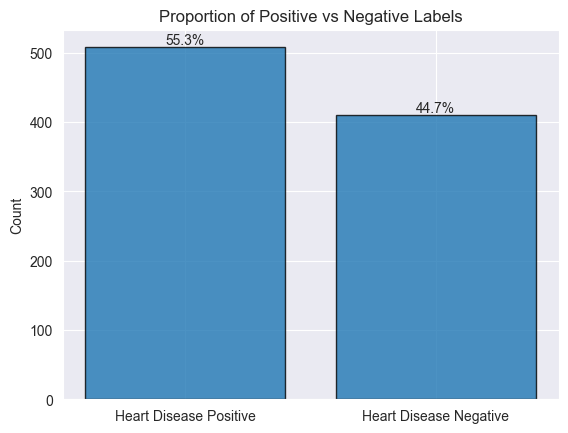

In [28]:
fig, ax = plt.subplots(1, 1)
bar_data = df["HeartDisease"].value_counts()
ax.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)

ax.set_xticks([0, 1])
ax.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])

for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax.set_ylabel("Count")
ax.set_title("Proportion of Positive vs Negative Labels")
plt.show()

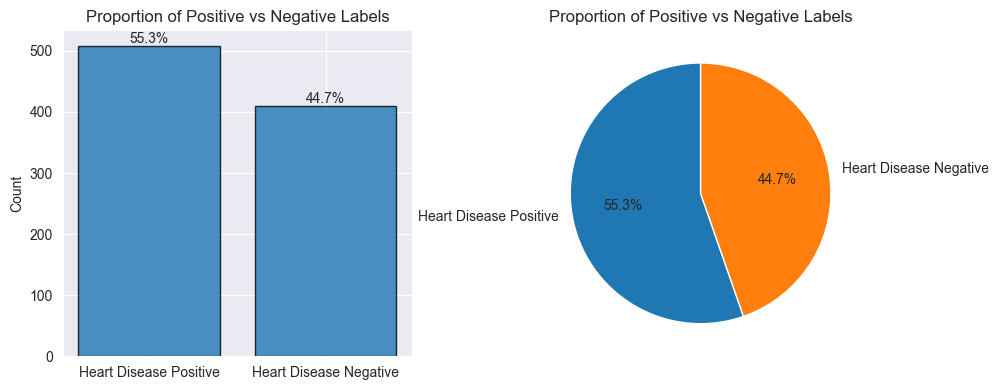

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Bar chart
ax_bar = axes[0]
bar_data = df["HeartDisease"].value_counts()
ax_bar.bar([0, 1], bar_data, edgecolor="black", alpha=0.8)
ax_bar.set_xticks([0, 1])
ax_bar.set_xticklabels(["Heart Disease Positive", "Heart Disease Negative"])
for i, count in enumerate(bar_data):
    percentage = count / bar_data.sum() * 100
    ax_bar.text(i, count, f"{percentage:.1f}%", ha="center", va="bottom")
ax_bar.set_ylabel("Count")
ax_bar.set_title("Proportion of Positive vs Negative Labels")

# Pie chart
ax_pie = axes[1]
labels = ["Heart Disease Positive", "Heart Disease Negative"]
sizes = bar_data.values
ax_pie.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax_pie.set_title("Proportion of Positive vs Negative Labels")

plt.tight_layout()
plt.show()


### How are continuous variables distributed (in particular, are they normally distributed)?

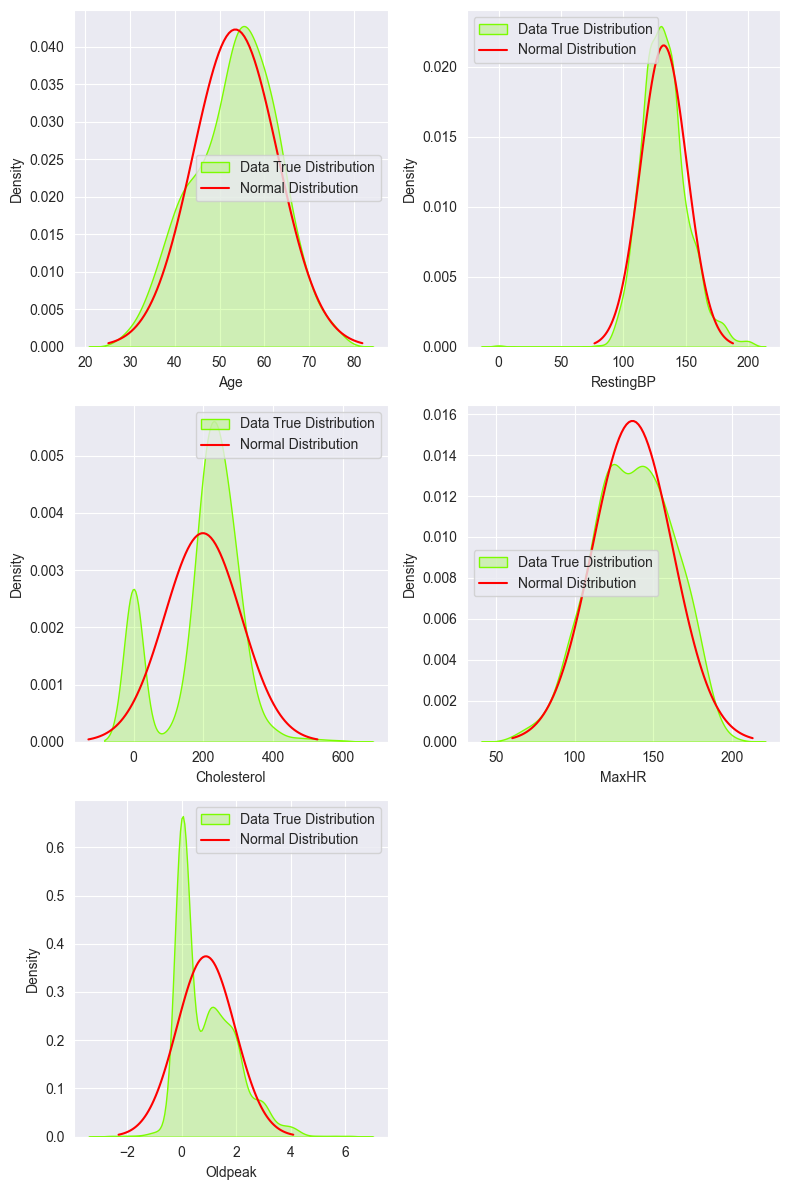

In [44]:
continuous_feature_names = numerical_features.columns.tolist()

num_features = len(continuous_feature_names)
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(3, 2, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for the feature
    sns.kdeplot(df[cont_feature], ax=ax_kde, fill=True, color="lawngreen", label="Data True Distribution")

    # Add normal distribution curve
    mean = df[cont_feature].mean()
    sd = df[cont_feature].std()
    x = np.linspace(mean - 3 * sd, mean + 3 * sd, 100)
    y = stats.norm.pdf(x, mean, sd)
    ax_kde.plot(x, y, color="red", label="Normal Distribution")
    ax_kde.legend()  # Add legend to the current subplot


# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

# plt.legend()
plt.tight_layout()
plt.show()

It looks like cholesterol was set to 0 as a null value, because people can't actually have 0 cholesterol

Numerical features and their relationship with Heart Disease

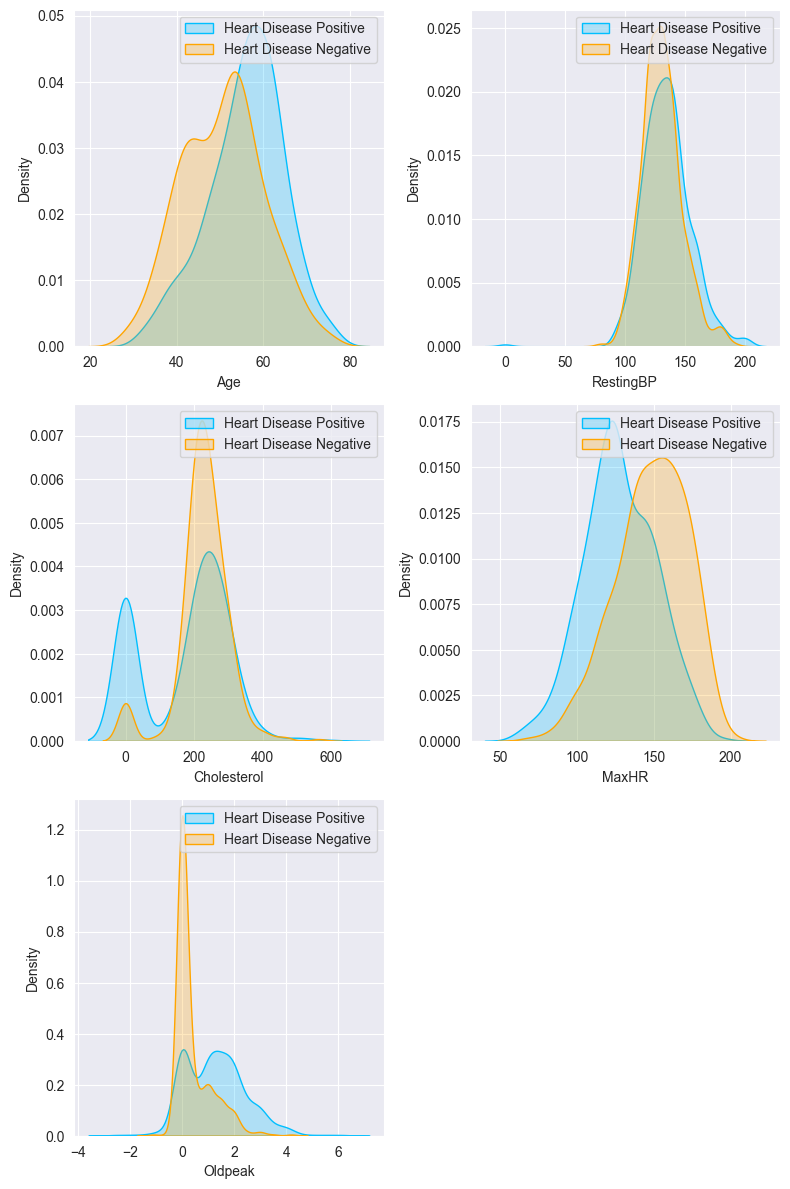

In [31]:
positive = df[df["HeartDisease"] == 1]  # Subset of data for heart failure cases
negative = df[df["HeartDisease"] == 0]  # Subset of data for non-heart failure cases


num_features = len(continuous_feature_names)
num_rows = 3
num_cols = 2

fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))

for i, cont_feature in enumerate(numerical_features):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax_kde = axes[row, col]

    # Plot KDE for heart failure positive cases
    sns.kdeplot(positive[cont_feature], ax=ax_kde, fill=True, color="deepskyblue", label="Heart Disease Positive")

    # Plot KDE for heart failure negative cases
    sns.kdeplot(negative[cont_feature], ax=ax_kde, fill=True, color="orange", label="Heart Disease Negative")

    ax_kde.legend()

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


compare mean of each feature for positive vs negative

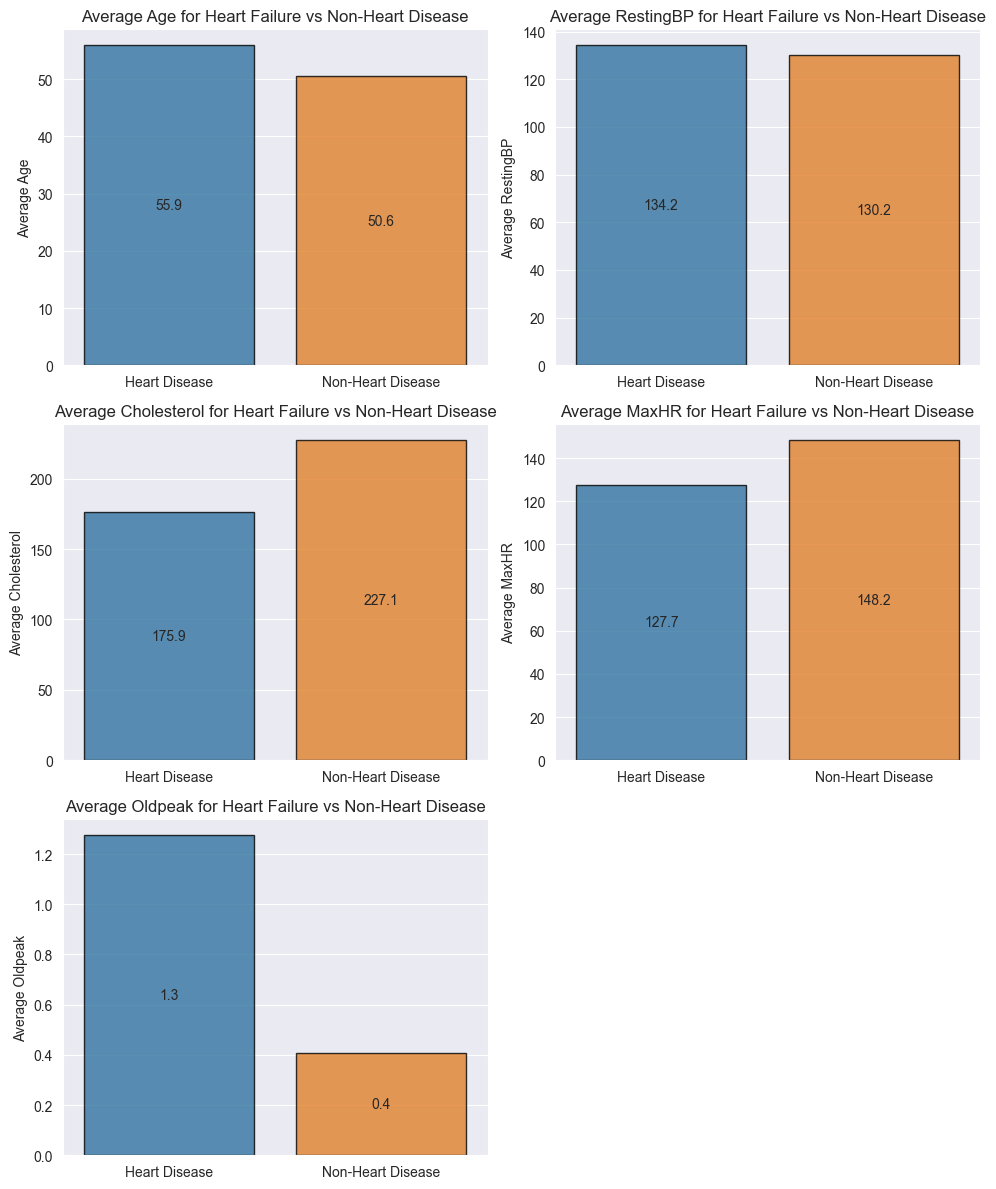

In [32]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))

# Looping through each feature
for i, feature in enumerate(continuous_feature_names):
    row = i // 2  # Calculate the row index for the subplot
    col = i % 2  # Calculate the column index for the subplot

    avg_heart_failure = positive[feature].mean()
    avg_non_heart_failure = negative[feature].mean()

    # Creating the bar chart for the current feature
    ax = axes[row, col]
    # ax.bar(["Heart Disease", "Non-Heart Disease"], [avg_heart_failure, avg_non_heart_failure])
    sns.barplot(x=["Heart Disease", "Non-Heart Disease"], y=[avg_heart_failure, avg_non_heart_failure], ax=ax, edgecolor="black", alpha=0.8)
    ax.set_ylabel("Average " + feature)
    ax.set_title("Average " + feature + " for Heart Failure vs Non-Heart Disease")

    # Adding annotations to the bars
    ax.annotate(f"{avg_heart_failure:.1f}", xy=(0, avg_heart_failure/2), ha="center", va="center")
    ax.annotate(f"{avg_non_heart_failure:.1f}", xy=(1, avg_non_heart_failure/2), ha="center", va="center")

# Remove the empty subplot in the bottom right corner
fig.delaxes(axes[2, 1])

# Adjusting the layout and spacing
plt.tight_layout()

# Displaying the chart
plt.show()


### How many examples are there of each categorical variable?

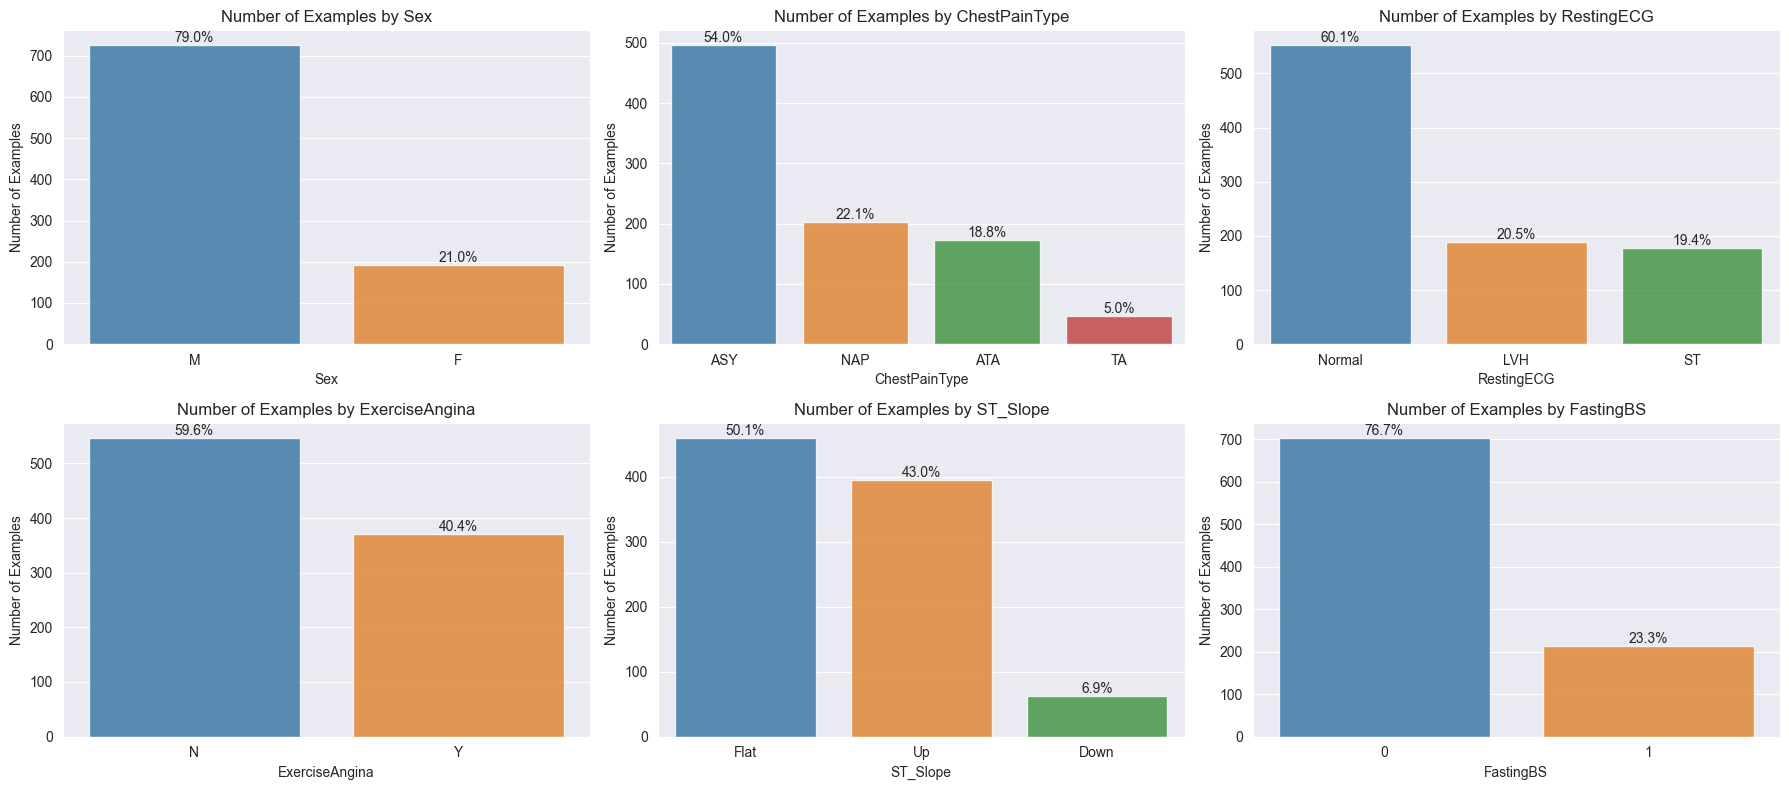

In [37]:
categorical_feature_names = categorical_features.columns.to_list() + ["FastingBS"]

num_features = len(categorical_feature_names)
num_rows = 2
num_cols = math.ceil(num_features / num_rows)


fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))

for i, cat_feature in enumerate(categorical_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    # Calculate number of examples and percentages for each category
    category_counts = df[cat_feature].value_counts()
    category_percentages = category_counts / len(df) * 100

    ax = axes[row, col]

    # Create bar plot for number of examples
    sns.barplot(x=category_counts.index, y=category_counts.values, ax=ax)

    ax.set_xlabel(cat_feature)
    ax.set_ylabel("Number of Examples")
    ax.set_title(f"Number of Examples by {cat_feature}")

    # Add percentage annotations
    for j, count in enumerate(category_counts):
        percentage = category_percentages[j]
        ax.text(j, count, f'{percentage:.1f}%', ha='center', va='bottom')

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

### How does each categorical variable change in conjunction with the target variable?

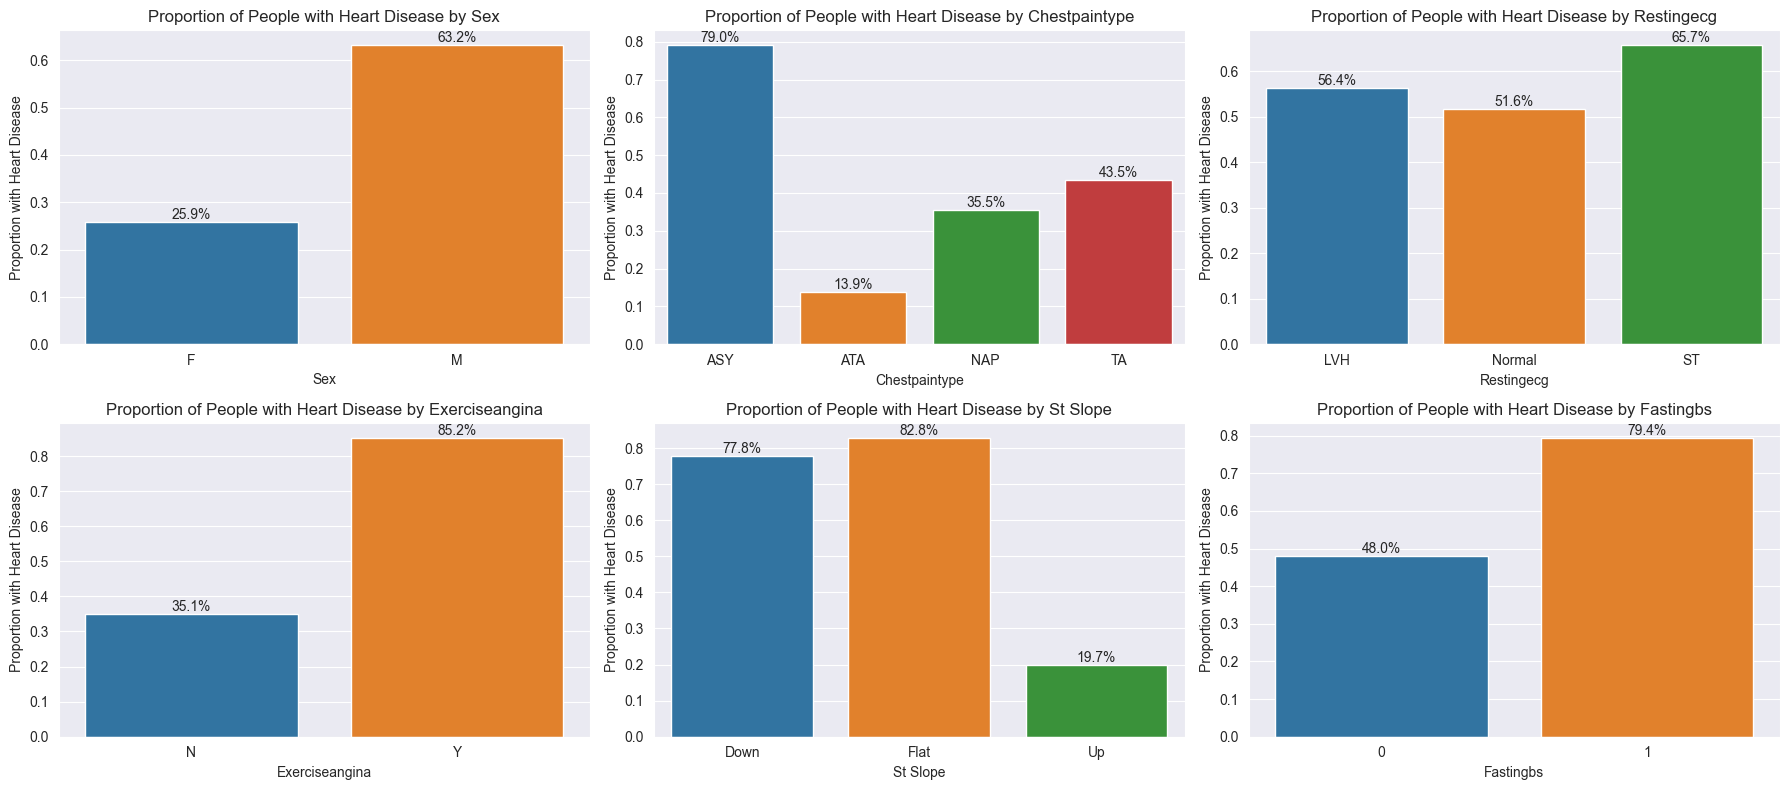

In [40]:
num_features = len(categorical_feature_names)
num_rows = 2
num_cols = math.ceil(num_features / num_rows)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6 * num_cols, 4 * num_rows))

for i, cat_feature in enumerate(categorical_feature_names):
    row = i // num_cols  # Calculate the row index for the subplot
    col = i % num_cols  # Calculate the column index for the subplot

    ax = axes[row, col]

    # Calculate probabilities of heart failure for each category
    category_probabilities = df.groupby(cat_feature)["HeartDisease"].mean()

    # Create bar plot
    bar_plot = sns.barplot(x=category_probabilities.index, y=category_probabilities.values, ax=ax)

    label = cat_feature.replace("_", " ").title()
    ax.set_xlabel(label)
    ax.set_ylabel("Proportion with Heart Disease")
    ax.set_title(f"Proportion of People with Heart Disease by {label}")

    total = category_probabilities.sum()
    for j, p in enumerate(bar_plot.patches):
        percentage = category_probabilities.values[j] * 100
        ax.text(p.get_x() + p.get_width() / 2, p.get_height(), f"{percentage:.1f}%", ha="center", va="bottom")

# Remove empty subplots
if num_features < num_rows * num_cols:
    for i in range(num_features, num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()


# Feature engineering and scaling

In [50]:
df2 = df.copy(deep=True)  # make a copy of the original data which we will modify

# Initialize the scalers
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()  # not clear this was required for 'Age', 'RestingBP', or, 'MaxHR' because those were already looking pretty close to Gaussian. Further normalization here is unlikely to hurt, however. A further investigation into normality with QQ-plots and the shapiro wilk test could be a future direction and dictate whether those features get StandardScaler applied to them

# Apply both scalers to each continuous variable
for feature in continuous_feature_names:
    # Perform MinMax scaling
    min_max_scaled_data = min_max_scaler.fit_transform(df2[[feature]])

    # Perform Standard scaling on the MinMax scaled data
    min_max_standard_scaled_data = standard_scaler.fit_transform(min_max_scaled_data)

    # Update the original DataFrame with the scaled data
    df2[feature] = min_max_standard_scaled_data.flatten()

df2.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,-1.433140,M,ATA,0.410909,0.825070,0,Normal,1.382928,N,-0.832432,Up,0
1,-0.478484,F,NAP,1.491752,-0.171961,0,Normal,0.754157,N,0.105664,Flat,1
2,-1.751359,M,ATA,-0.129513,0.770188,0,ST,-1.525138,N,-0.832432,Up,0
3,-0.584556,F,ASY,0.302825,0.139040,0,Normal,-1.132156,Y,0.574711,Flat,1
4,0.051881,M,NAP,0.951331,-0.034755,0,Normal,-0.581981,N,-0.832432,Up,0


In [51]:
# one hot encoding of categorical variables
df2 = pd.get_dummies(df2, columns=categorical_feature_names, dtype=int)
df2.head()

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,...,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up,FastingBS_0,FastingBS_1
0,-1.433140,0.410909,0.825070,1.382928,-0.832432,0,0,1,0,1,...,0,1,0,1,0,0,0,1,1,0
1,-0.478484,1.491752,-0.171961,0.754157,0.105664,1,1,0,0,0,...,0,1,0,1,0,0,1,0,1,0
2,-1.751359,-0.129513,0.770188,-1.525138,-0.832432,0,0,1,0,1,...,0,0,1,1,0,0,0,1,1,0
3,-0.584556,0.302825,0.139040,-1.132156,0.574711,1,1,0,1,0,...,0,1,0,0,1,0,1,0,1,0
4,0.051881,0.951331,-0.034755,-0.581981,-0.832432,0,0,1,0,0,...,0,1,0,1,0,0,0,1,1,0


# Modelling and Predicting

In [52]:
x_train, x_test, y_train, y_test = train_test_split(df2.drop("HeartDisease", axis=1), df2["HeartDisease"], test_size=0.2, random_state=1)

In [118]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import itertools
from sklearn.metrics import confusion_matrix

def calculate_results(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred)
    # Calculate model precision, recall and f1 score using "weighted average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    # Calculate model specificity
    tn, fp, _, _ = confusion_matrix(y_true, y_pred).ravel()
    model_specificity = tn / (tn + fp)


    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1,
                     "specificity": model_specificity}
    return model_results

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(6, 6), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

Initialize dataframe to easily keep track of experiments in an organized way

In [99]:
models_df = pd.DataFrame({"experiment_name": [], "accuracy": [], "precision": [], "recall": [], "f1": [], "specificity": []})

def add_experiment(models: pd.DataFrame, experiment_name: str, predictions: np.ndarray) -> pd.DataFrame:
    """
    Add a new experiment to the models_df DataFrame.

    Args:
        models: DataFrame to store the models' results.
        experiment_name: Name of the experiment.
        predictions: The model's predicted labels

    Returns:
        Updated models DataFrame with the new experiment.
    """
    if len(models) and experiment_name in models["experiment_name"].values:
        # Experiment name already exists in the DataFrame. only runs the if block if there's at least one entry
        print(f"{experiment_name} already exists in dataframe. Skipping addition.")
        return models

    new_row = {"experiment_name": experiment_name}
    results = calculate_results(y_true=y_test, y_pred=predictions)
    new_row.update(results)

    models.loc[len(models_df)] = new_row
    return models


logistic_regressor1 already exists in dataframe. Skipping addition.


,experiment_name,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,0.896739,0.896559,0.896739,0.896622,0.864865
1,random_forest1,0.902174,0.901937,0.902174,0.901945,0.864865


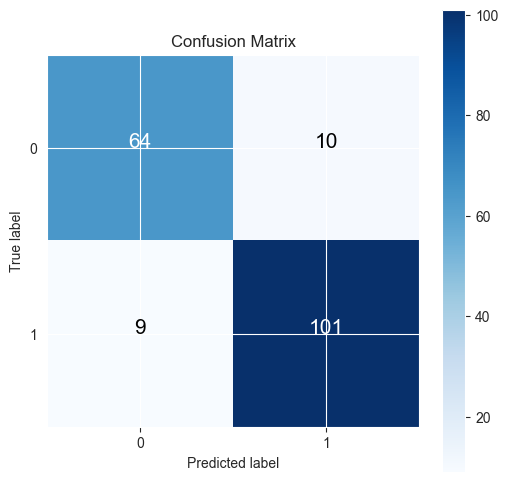

In [126]:
logistic_regressor1 = LogisticRegression(random_state=10)
logistic_regressor1.fit(x_train, y_train)

logistic_regressor1_predictions = logistic_regressor1.predict(x_test)
models_df = add_experiment(models_df, "logistic_regressor1", logistic_regressor1_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=logistic_regressor1_predictions, figsize=(6, 6))

random_forest1 already exists in dataframe. Skipping addition.


,experiment_name,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,0.896739,0.896559,0.896739,0.896622,0.864865
1,random_forest1,0.902174,0.901937,0.902174,0.901945,0.864865


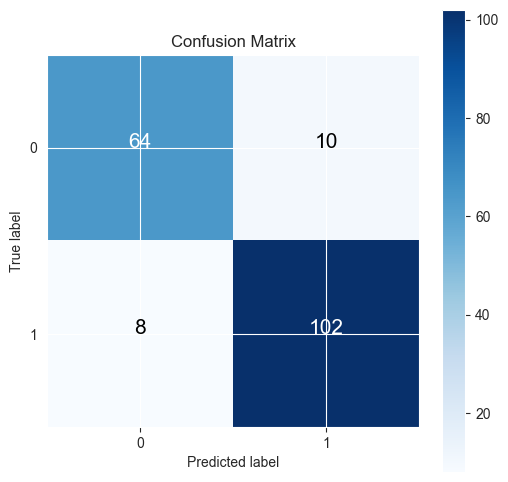

In [104]:
random_forest1 = RandomForestClassifier(random_state=10)
random_forest1.fit(x_train, y_train)
random_forest1_predictions = random_forest1.predict(x_test)

models_df = add_experiment(models_df, "random_forest1", random_forest1_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=random_forest1_predictions, figsize=(6, 6))

,experiment_name,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,0.896739,0.896559,0.896739,0.896622,0.864865
1,random_forest1,0.902174,0.901937,0.902174,0.901945,0.864865
2,svm_model1,0.907609,0.907444,0.907609,0.907274,0.864865


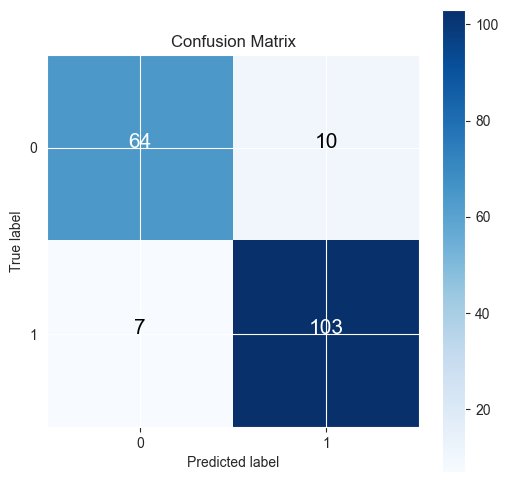

In [127]:
from sklearn.svm import SVC

svm_model1 = SVC(random_state=10)
svm_model1.fit(x_train, y_train)

svm_model1_predictions = svm_model1.predict(x_test)

models_df = add_experiment(models_df, "svm_model1", svm_model1_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=svm_model1_predictions, figsize=(6, 6))

gnb_model already exists in dataframe. Skipping addition.


,experiment_name,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,0.896739,0.896559,0.896739,0.896622,0.864865
1,random_forest1,0.902174,0.901937,0.902174,0.901945,0.864865
2,svm_model1,0.907609,0.907444,0.907609,0.907274,0.864865
3,gnb_model,0.902174,0.902799,0.902174,0.902377,0.891892


,experiment_name,accuracy,precision,recall,f1,specificity
0,logistic_regressor1,0.896739,0.896559,0.896739,0.896622,0.864865
1,random_forest1,0.902174,0.901937,0.902174,0.901945,0.864865
2,svm_model1,0.907609,0.907444,0.907609,0.907274,0.864865
3,gnb_model,0.902174,0.902799,0.902174,0.902377,0.891892
4,bnb_model,0.907609,0.908660,0.907609,0.907888,0.905405


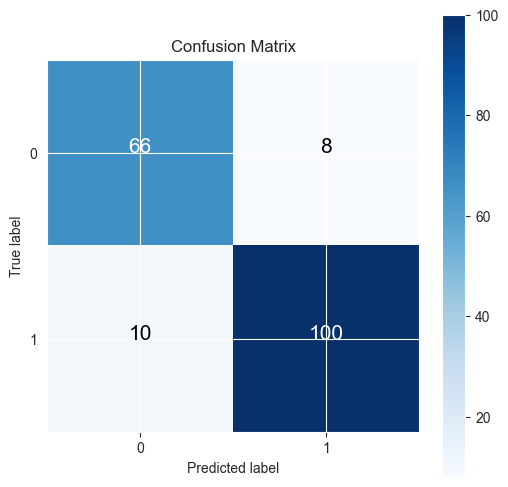

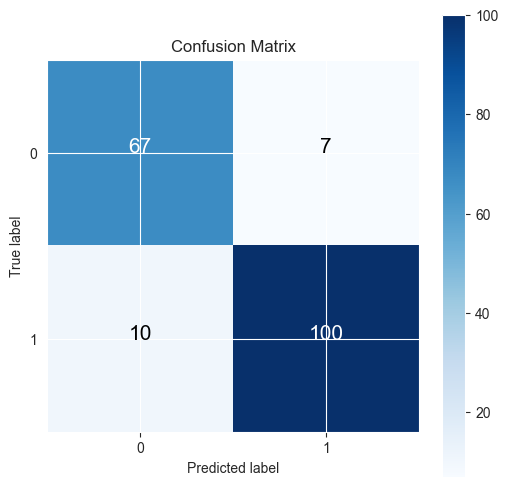

In [131]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# Gaussian Naive Bayes
gnb_model = GaussianNB()
gnb_model.fit(x_train, y_train)
gnb_predictions = gnb_model.predict(x_test)

models_df = add_experiment(models_df, "gnb_model", gnb_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=gnb_predictions, figsize=(6, 6))

# Bernoulli Naive Bayes
bnb_model = BernoulliNB()
bnb_model.fit(x_train, y_train)
bnb_predictions = bnb_model.predict(x_test)


models_df = add_experiment(models_df, "bnb_model", bnb_predictions)
display(models_df)
make_confusion_matrix(y_true=y_test, y_pred=bnb_predictions, figsize=(6, 6))

In [124]:
# trying a deeplearning model

import tensorflow as tf

tf.random.set_seed(1)

dl_model1 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(len(x_train.columns),)),
    tf.keras.layers.Dense(110, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

dl_model1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

dl_model1_history = dl_model1.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

Epoch 1/5
23/23 [==============================] - 0s 3ms/step - loss: 0.5361 - accuracy: 0.7738 - val_loss: 0.4132 - val_accuracy: 0.8913
Epoch 2/5
23/23 [==============================] - 0s 901us/step - loss: 0.3955 - accuracy: 0.8392 - val_loss: 0.3235 - val_accuracy: 0.8913
Epoch 3/5
23/23 [==============================] - 0s 994us/step - loss: 0.3442 - accuracy: 0.8569 - val_loss: 0.2893 - val_accuracy: 0.8967
Epoch 4/5
23/23 [==============================] - 0s 1ms/step - loss: 0.3252 - accuracy: 0.8706 - val_loss: 0.2813 - val_accuracy: 0.9076
Epoch 5/5
23/23 [==============================] - 0s 1ms/step - loss: 0.3144 - accuracy: 0.8706 - val_loss: 0.2776 - val_accuracy: 0.9130


6/6 [==============================] - 0s 465us/step


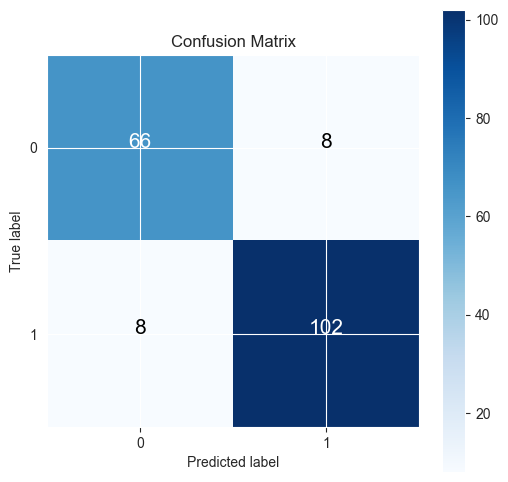

In [125]:
dl_model1_preds = np.round(dl_model1.predict(x_test)).flatten()
make_confusion_matrix(y_test, dl_model1_preds)